In [2]:
import mplfinance as mpf
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [3]:
from datetime import date
from jugaad_data.nse import stock_csv, stock_df

In [4]:
df = pd.read_csv('MRF.csv')

In [5]:
df.set_index("DATE")
df['DATE'] = pd.to_datetime(df['DATE'])

In [6]:
df.columns

Index(['Unnamed: 0', 'DATE', 'SERIES', 'OPEN', 'HIGH', 'LOW', 'PREV. CLOSE',
       'LTP', 'CLOSE', 'VWAP', '52W H', '52W L', 'VOLUME', 'VALUE',
       'NO OF TRADES', 'SYMBOL'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5687 entries, 0 to 5686
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    5687 non-null   int64         
 1   DATE          5687 non-null   datetime64[ns]
 2   SERIES        5687 non-null   object        
 3   OPEN          5687 non-null   float64       
 4   HIGH          5687 non-null   float64       
 5   LOW           5687 non-null   float64       
 6   PREV. CLOSE   5687 non-null   float64       
 7   LTP           5687 non-null   float64       
 8   CLOSE         5687 non-null   float64       
 9   VWAP          5687 non-null   float64       
 10  52W H         5671 non-null   float64       
 11  52W L         5671 non-null   float64       
 12  VOLUME        5687 non-null   int64         
 13  VALUE         5687 non-null   float64       
 14  NO OF TRADES  5687 non-null   int64         
 15  SYMBOL        5687 non-null   object  

In [8]:
len(df)

5687

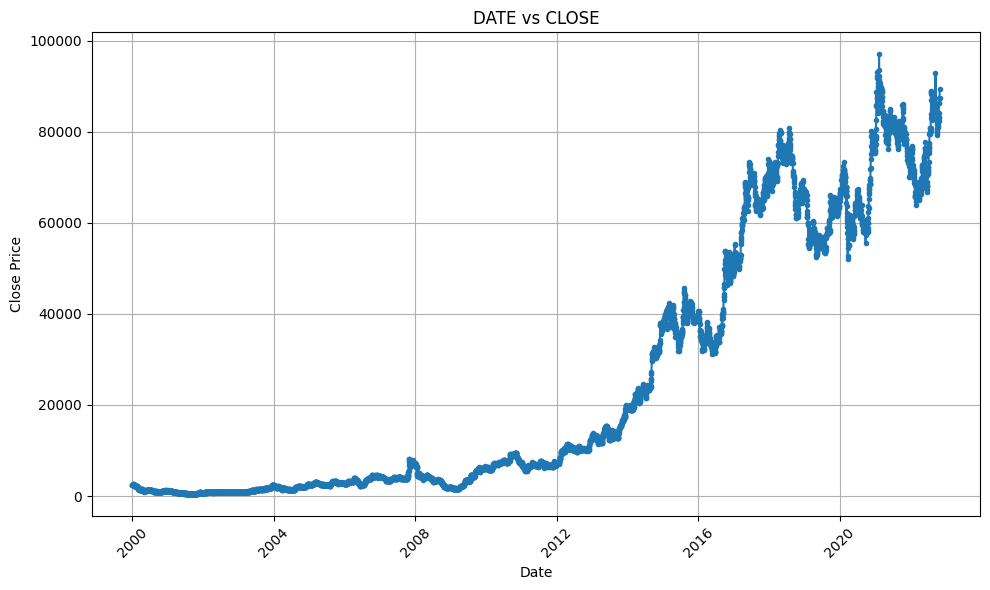

In [9]:
df = df.sort_values(by='DATE')
plt.figure(figsize=(10, 6))

plt.plot(df["DATE"], df['CLOSE'], marker='.', linestyle='-')
plt.title('DATE vs CLOSE')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
split_size=int(0.8*len(df))
print(split_size)

4549


In [11]:
new_df = df[['DATE', 'CLOSE']].copy()
new_df.set_index('DATE', inplace=True)
new_df.index = pd.to_datetime(new_df.index)


In [12]:
new_df.head()

,CLOSE
DATE,
2000-01-03,2354.80
2000-01-04,2426.10
2000-01-05,2350.00
2000-01-06,2536.85
2000-01-07,2470.80


In [13]:
timesteps=new_df.index.to_numpy()
prices=new_df["CLOSE"].to_numpy()


In [14]:
X_train,y_train=timesteps[:split_size],prices[:split_size]
X_test,y_test=timesteps[split_size:],prices[split_size:]

In [15]:
len(X_train),len(y_train),len(X_test),len(y_test)

(4549, 4549, 1138, 1138)

In [16]:
def plot_time_series(timesteps,values,format=".",start=0,end=None,label=None):
    plt.plot(timesteps[start:end],values[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)


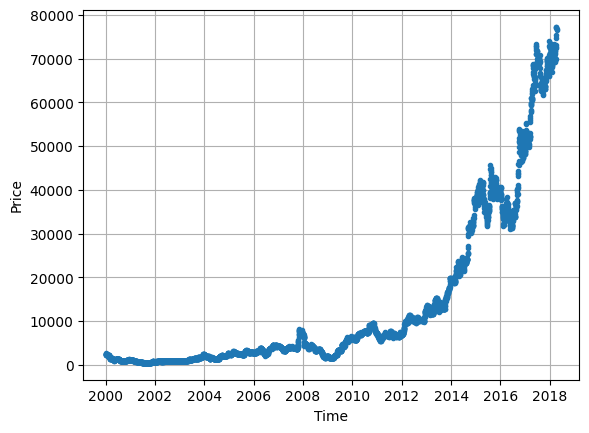

In [17]:
plot_time_series(timesteps=X_train,values=y_train,label="Train_data")

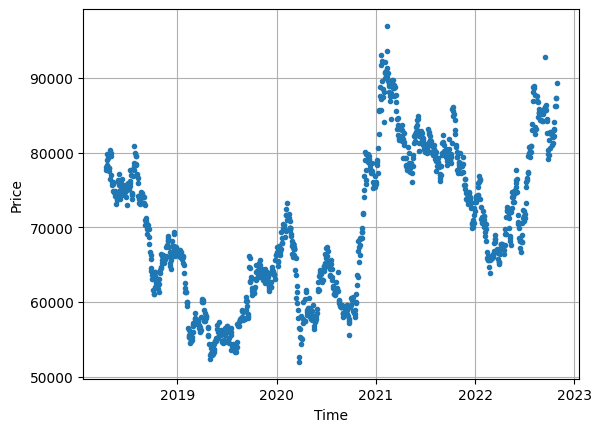

In [18]:
plot_time_series(timesteps=X_test,values=y_test,label="Test_data")

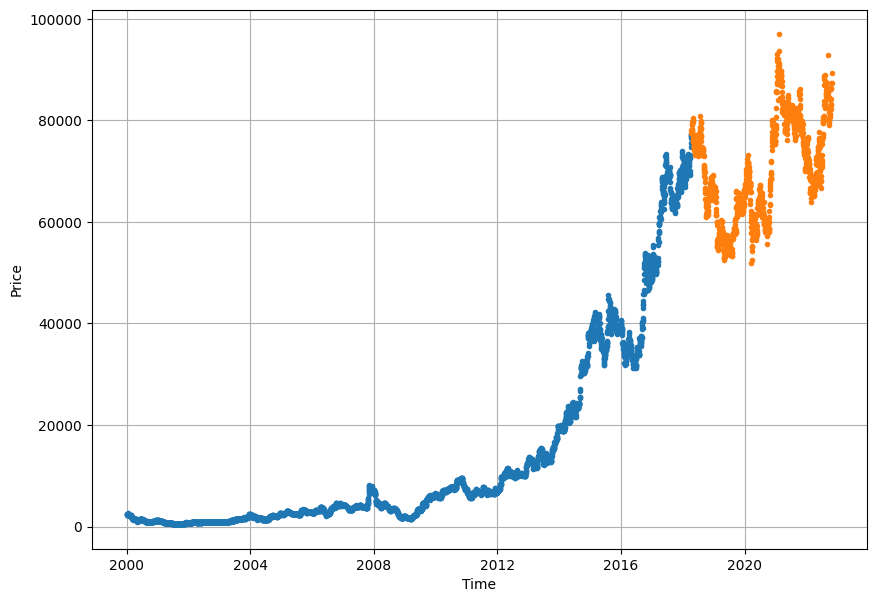

In [19]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=y_train,label="Train_data")
plot_time_series(timesteps=X_test,values=y_test,label="Test_data")

In [20]:
def mean_absolute_scaled_error(y_true,y_pred):
    mae=tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_pred[1:]))
    return mae/mae_naive_no_season

In [21]:
HORIZON = 1
WINDOW_SIZE = 7

In [22]:
def get_labelled_data(x, horizon=HORIZON):
    return x[:,:-horizon],x[:,-horizon:]

In [23]:
test_window,test_label = get_labelled_data(tf.expand_dims(tf.range(8),axis=0))
test_window,test_label

2024-01-18 21:20:39.326515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-18 21:20:39.588532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-18 21:20:39.588576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-18 21:20:39.591584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-18 21:20:39.591630: I external/local_xla/xla/stream_executor

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

In [24]:
def make_windows(x,window_size=WINDOW_SIZE,horizon=HORIZON):
    window_step=np.expand_dims(np.arange(window_size+horizon),axis=0)
    window_indexes=window_step+np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
    windowed_array=x[window_indexes]
    windows,labels=get_labelled_data(windowed_array,horizon=horizon)
    return windows,labels

In [25]:
full_windows,full_labels = make_windows(prices,window_size = WINDOW_SIZE,horizon=HORIZON)

In [26]:
len(full_windows),len(full_labels)

(5680, 5680)

In [27]:
for i in range(3):
    print(f"Window: {full_windows[i]} --> Label: {full_labels[i]}")

Window: [2354.8  2426.1  2350.   2536.85 2470.8  2497.6  2315.  ] --> Label: [2500.2]
Window: [2426.1  2350.   2536.85 2470.8  2497.6  2315.   2500.2 ] --> Label: [2640.2]
Window: [2350.   2536.85 2470.8  2497.6  2315.   2500.2  2640.2 ] --> Label: [2514.75]


In [28]:
n=3
for i in range(n):
    print(f"Window: {full_windows[i-n]} --> Label: {full_labels[i-n]}")

Window: [81350.15 82267.95 83088.15 83149.45 84171.8  86224.8  86291.55] --> Label: [87342.85]
Window: [82267.95 83088.15 83149.45 84171.8  86224.8  86291.55 87342.85] --> Label: [87362.85]
Window: [83088.15 83149.45 84171.8  86224.8  86291.55 87342.85 87362.85] --> Label: [89368.3]


In [29]:
def make_train_test_splits(windows,labels,test_split=0.2):
    splits_size=int(len(windows))*(1-test_split)
    train_windows=windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows,test_windows,train_labels,test_labels

In [30]:
train_windows,test_windows,train_labels,test_labels = make_train_test_splits(full_windows,full_labels,test_split=0.2)

In [31]:
len(train_windows),len(test_windows),len(train_labels),len(test_labels)

(4549, 1131, 4549, 1131)

In [32]:
train_windows[:5],train_labels[:5]

(array([[2354.8 , 2426.1 , 2350.  , 2536.85, 2470.8 , 2497.6 , 2315.  ],
        [2426.1 , 2350.  , 2536.85, 2470.8 , 2497.6 , 2315.  , 2500.2 ],
        [2350.  , 2536.85, 2470.8 , 2497.6 , 2315.  , 2500.2 , 2640.2 ],
        [2536.85, 2470.8 , 2497.6 , 2315.  , 2500.2 , 2640.2 , 2514.75],
        [2470.8 , 2497.6 , 2315.  , 2500.2 , 2640.2 , 2514.75, 2538.2 ]]),
 array([[2500.2 ],
        [2640.2 ],
        [2514.75],
        [2538.2 ],
        [2439.25]]))

In [33]:
import os

def create_model_checkpoint(model_name,save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                              save_best_only=True,
                                              verbose=0)

In [34]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation = "relu"),
    tf.keras.layers.Dense(HORIZON,activation = "linear")
],name = "model_1_dense")

In [35]:
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ["mae","mse"])

In [36]:
tf.cast(train_windows, tf.float32)
tf.cast(train_labels, tf.float32)
tf.cast(test_windows, tf.float32)
tf.cast(test_labels, tf.float32)


<tf.Tensor: shape=(1131, 1), dtype=float32, numpy=
array([[77961.45],
       [77948.4 ],
       [77496.4 ],
       ...,
       [87342.85],
       [87362.85],
       [89368.3 ]], dtype=float32)>

In [38]:
model_1.fit(x=train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data=(test_windows,test_labels))
            # callbacks = [create_model_checkpoint(model_name= model_1.name)])

Epoch 1/100


36/36 [==============================] - 0s 7ms/step - loss: 202.5091 - mae: 202.5091 - mse: 189547.3125 - val_loss: 830.3621 - val_mae: 830.3621 - val_mse: 1456931.6250
Epoch 2/100
36/36 [==============================] - 0s 5ms/step - loss: 201.7345 - mae: 201.7345 - mse: 187447.7031 - val_loss: 830.7990 - val_mae: 830.7990 - val_mse: 1460551.7500
Epoch 3/100
36/36 [==============================] - 0s 8ms/step - loss: 206.7799 - mae: 206.7799 - mse: 199645.7344 - val_loss: 1527.7413 - val_mae: 1527.7413 - val_mse: 3268051.7500
Epoch 4/100
36/36 [==============================] - 0s 11ms/step - loss: 226.8089 - mae: 226.8089 - mse: 229490.5781 - val_loss: 930.4489 - val_mae: 930.4489 - val_mse: 1723407.7500
Epoch 5/100
36/36 [==============================] - 0s 11ms/step - loss: 200.0987 - mae: 200.0987 - mse: 190568.3281 - val_loss: 832.8835 - val_mae: 832.8835 - val_mse: 1454382.6250
Epoch 6/100
36/36 [==============================] - 0s 9ms/step - loss: 197.8209 - mae: 197.8209 